# Spam Mail Classifier

In [1]:
# Importing the required packages
import numpy as np
import pandas as pd

import nltk
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

### About the data
This dataset consists of raw mail classified as whether they are spam or not. I will be using this data to make a model to predict if a mail is spam or not. 

In [2]:
# Importing data
data = pd.read_csv("nlpdata.csv")

In [3]:
data.head(10)

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
5,1,------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...,00187.efd97ab2034b3384606e21db00014ecb
6,1,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",00500.85b72f09f6778a085dc8b6821965a76f
7,1,<HR>\n\n<html>\n\n<head>\n\n <title>Secured I...,00493.1c5f59825f7a246187c137614fb1ea82
8,1,"<table width=""600"" border=""20"" align=""center"" ...",00012.381e4f512915109ba1e0853a7a8407b2
9,1,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Cont...",00487.139a2f4e8edbbdd64441536308169d74


This is what the data looks like. It is important to have a look at the data before getting to analysis and prediction as it gives us an idea of what we are dealing with. 

In [4]:
# Finding the number of rows and columns in the dataset
data.shape

(5796, 3)

In [5]:
# Checking for null values
data.isna().sum()

CATEGORY     0
MESSAGE      0
FILE_NAME    0
dtype: int64

There are no null values in the dataset, so we can proceed.

In [6]:
# We do not need the File name, so we can delete this column
data = data.drop('FILE_NAME', axis = 1)

In [7]:
# Getting more information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CATEGORY  5796 non-null   int64 
 1   MESSAGE   5796 non-null   object
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


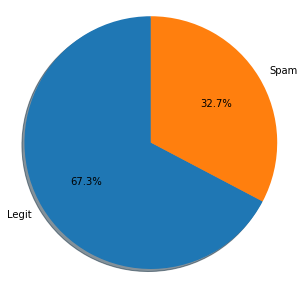

In [8]:
fig = plt.figure(figsize=(5, 5))
labels = "Legit", "Spam"
sizes = data["CATEGORY"].value_counts()
plt.pie(sizes, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
plt.axis('equal')
plt.show()

In [9]:
data["CATEGORY"].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

This dataset contains 5796 raw text messages. It is not balanced as only 1896 out of 5796 texts are spam and 3900 are not spam. 

In [10]:
# Balancing the dataset
spam = data.loc[data['CATEGORY'] == 1]
notspam = data.loc[data['CATEGORY'] == 0]
notspam = notspam.head(1896)

In [11]:
spam_bal = spam['MESSAGE'].to_numpy()
notspam_bal = notspam['MESSAGE'].to_numpy()
messages = np.concatenate((spam_bal, notspam_bal), axis = 0)
print("Number of messages: ", len(messages))

Number of messages:  3792


Now we have a balanced dataset, with equal number of spam and legit messages.   

In [12]:
# make a numpy array representing labels of the messages
labels = np.append(np.ones((len(notspam_bal))), np.zeros((len(spam_bal))))

In [13]:
# Making the new dataframe which is balanced
data_frame = pd.DataFrame({'CATEGORY': labels, 'MESSAGE': messages})

### Cleaning the text
I will now define a function that will help in standardizing the text(removing hyperlinks, converting to lower case, removing words that don't hold value, etc.)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khannashivangi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stopwords_english = stopwords.words('english')

In [16]:
def clean_text(text):
    stemmer = SnowballStemmer("english")
    stopwords_english = stopwords.words('english')
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    words = word_tokenize(cleaned_text.lower())
    words_clean = []
    for word in words:
        if (word not in stopwords_english and word.isalpha()):
            stem_word = stemmer.stem(word)
            words_clean.append(word)
    return words_clean

### MultinomialNB model
The multinomial Naive Bayes classifier is suitable for this type of classification (word count for text classification). 
Since this model prefers numerical feature vectors with fixed size, I used the CountVectorizer to convert text into a matrix of token counts.

In [17]:
# Splitting the data into training set and test set
train_x, test_x, train_y, test_y = train_test_split(data_frame['MESSAGE'], data_frame['CATEGORY'], test_size = 0.30, random_state = 88)

In [18]:
vectorizer = CountVectorizer(stop_words = 'english', analyzer = clean_text)
train_x_features = vectorizer.fit_transform(train_x)
test_x_features = vectorizer.transform(test_x)

In [19]:
classifier = MultinomialNB()
classifier.fit(train_x_features,train_y)

MultinomialNB()

In [20]:
# Predicting if a mail is spam or legit on the test set
yhat = classifier.predict(test_x_features)

In [21]:
# Calculating the accuracy of the model
metrics.accuracy_score(test_y, yhat)

0.9824253075571178

The accuracy of my model is **98.24%**, which is a really good number. 

### Confusion matrix
[TN FP  
FN TP]


In [22]:
metrics.confusion_matrix(test_y, yhat)

array([[565,   5],
       [ 15, 553]])

As we can see, there are 5 false positives(legit mail classified as spam) and 15 false negatives(spam mail classified as legit). 

In [23]:
# Mails that were false positives
test_x[yhat > test_y]

3517    URL: http://www.newsisfree.com/click/-1,817167...
2593    All,\n\n\n\nIs it just me or has there been a ...
2608    ok, if an email address is not in my whitelist...
2319    Congrats, in the end...\n\n> "If they didn't h...
2246    URL: http://www.newsisfree.com/click/-5,853546...
Name: MESSAGE, dtype: object

In [24]:
# Mails that were false negatives
test_x[yhat < test_y]

142     ÄúºÃ£º\n\n    Èç¹û´ËÐÅ´òÈÅµ½Äú£¬ÎÒÃÇÉî¸Ð±§Ç¸£¬...
1883    PEhUTUw+PEhFQUQ+PFRJVExFPkV2IHlhcGltaSBhbWF09n...
1652    \n\nSEE a Teen Farm Girl Do it with her horse ...
853     NEW PRODUCT ANNOUNCEMENT\n\n\n\nFrom: OUTSOURC...
783     <META HTTP-EQUIV="Content-Type" CONTENT="text/...
126     <HTML><HEAD>\n\n<META http-equiv=Content-Type ...
264      \n\n\n\n                  Welcome to "Ghetto"...
163     =3C!DOCTYPE HTML PUBLIC =22-=2F=2FW3C=2F=2FDTD...
837     INSIGHT NEWS ALERT!\n\n\n\nA new issue of Insi...
553     In 1957, a monastery in Thailand was being rel...
1225    Hi Steph\n\n\n\n\n\nI have found the talent th...
1683    This is a multi-part message in MIME format.\n...
621     1075RxOo9-26l11\n\n\n\nINCREASE YOUR GAS MILEA...
45      PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...
238     >\n\n>µ×è¹µÑÇ ¡ÑºâÅ¡¸ØÃ¡Ô¨º¹ÍÔ¹àµÍÃìà¹çµ \n\...
Name: MESSAGE, dtype: object

### Summary
I was able to build a 98% accurate model. I used the CountVectorizer and MultinomialNB during this project.